<a href="https://colab.research.google.com/github/slunara/ratDetectorComputerVision/blob/main/auto_anotation_groundingDINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Rat Detector

Susana Luna - Computer Vision - Individual Assignment

Objective: Build a Rat Detector using YOLOv10 model and automatic annotation using GroundingDINO.



Let's make sure that we have access to GPU.

In [3]:
#!ls -lah /content/

total 16K
drwxr-xr-x 1 root root 4.0K Feb  8 10:38 .
drwxr-xr-x 1 root root 4.0K Feb  8 10:00 ..
drwxr-xr-x 4 root root 4.0K Feb  6 14:19 .config


In [4]:
!nvidia-smi

Sat Feb  8 10:39:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 1: Auto anotation

## Install libraries

- Grounding DINO
- Additional Deppendencies

In [7]:
import os
import torch
import roboflow
import supervision
import glob
import cv2
import supervision as sv
from typing import List
from roboflow import Roboflow
from PIL import Image
import imghdr

'imghdr' is deprecated and slated for removal in Python 3.13


In [8]:
HOME = os.getcwd()
print(HOME)

/content


In [9]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 36.51 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
Branch 'feature/more_compact_inference_api' set up to track remote branch 'feature/more_compact_inference_api' from 'origin'.
Switched to a new branch 'feature/more_compact_inference_api'
  Preparing metadata (setup.py) ... done


In [10]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
roboflow: 1.1.53 ; supervision: 0.4.0


In [11]:
# confirm that configuration file exist


CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [12]:
# download weights file

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [13]:
# confirm that weights file exist

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Download Raw Data

In [14]:
!rm -rf /content/ratDetectorComputerVision  # Remove old repo (if needed)
!git clone https://github.com/slunara/ratDetectorComputerVision.git /content/ratDetectorComputerVision

Cloning into '/content/ratDetectorComputerVision'...
remote: Enumerating objects: 459, done.
remote: Counting objects: 100% (459/459), done.
remote: Compressing objects: 100% (457/457), done.
remote: Total 459 (delta 4), reused 446 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (459/459), 9.24 MiB | 29.37 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Check the raw images quantity

In [15]:
image_folder = "/content/ratDetectorComputerVision/data"


image_extensions = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.gif", "*.tiff", "*.webp")
image_count = sum(len(glob.glob(os.path.join(image_folder, "**", ext), recursive=True)) for ext in image_extensions)

print(f"Total images on the folder: {image_count}")

Total images on the folder: 444


## Load GoundingDINO model

In [16]:
from groundingdino.util.inference import Model

Importing from timm.models.layers is deprecated, please import via timm.layers


In [17]:
%cd {HOME}/GroundingDINO

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Check how it works with one image

In [18]:
SOURCE_IMAGE_PATH = "/content/ratDetectorComputerVision/data/rat_1465.jpg"
CLASSES = ['rat']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


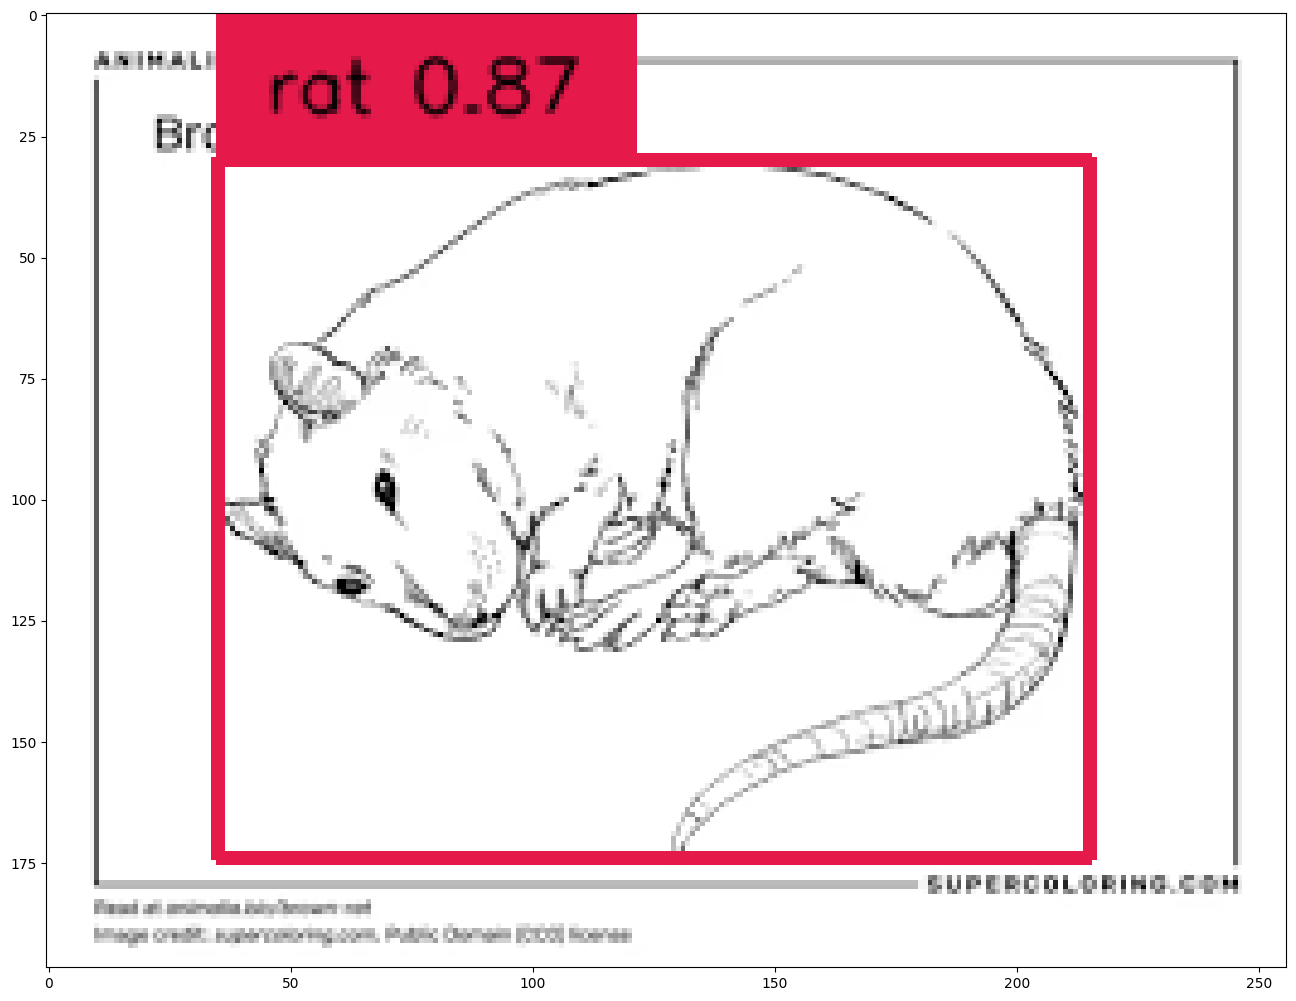

In [19]:
image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, confidence, class_id, _)
    in zip(labels, detections)]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Dataset auto anotation

In [21]:
def list_image_files(directory: str) -> List[str]:
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


def save_voc_xml(xml_string: str, file_path: str) -> None:
    with open(file_path, 'w') as f:
        f.write(xml_string)


def image_name_to_xml_name(image_name: str) -> str:
    base_name, _ = os.path.splitext(image_name)
    xml_name = f"{base_name}.xml"
    return xml_name

In [22]:
PROJECT_NAME = "ratsDetectionV2"
PROJECT_DESCRIPTION = "ratsClassification"
SOURCE_DIRECTORY_PATH = "/content/ratDetectorComputerVision/data"
CLASSES = ['rat']
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25

In [23]:
rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")

workspace = rf.workspace()

new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="object-detection",
    annotation="BoundingBox-Annotations")

loading Roboflow workspace...
loading Roboflow project...


In [24]:
def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

Change images with PNG format to JPEG to match filename extension.

In [25]:
image_path = "/content/ratDetectorComputerVision/data/rat_1465.jpg"

try:
    with Image.open(image_path) as img:
        print(f"Actual format: {img.format}")
except Exception as e:
    print(f"Error: {e}")

Actual format: PNG


In [26]:
image_dir = SOURCE_DIRECTORY_PATH


if not os.path.exists(image_dir):
    print(f"Directory '{image_dir}' not found!")
else:
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)

        if not os.path.isfile(file_path):
            continue

        actual_format = imghdr.what(file_path)

        # If the file is actually a PNG but doesn't have .png extension, print it
        if actual_format == "png" and not filename.lower().endswith(".png"):
            print(f"Incorrect PNG file: {filename} (should be .png)")

Incorrect PNG file: rat_812.jpg (should be .png)
Incorrect PNG file: rat_59.jpg (should be .png)
Incorrect PNG file: rat_241.jpg (should be .png)
Incorrect PNG file: rat_102.jpg (should be .png)
Incorrect PNG file: rat_1465.jpg (should be .png)
Incorrect PNG file: rat_1499.jpg (should be .png)
Incorrect PNG file: rat_319.jpg (should be .png)


In [27]:
image_dir = SOURCE_DIRECTORY_PATH


if not os.path.exists(image_dir):
    print(f"❌ Directory '{image_dir}' not found! Please check the path.")
else:

    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)


        if not os.path.isfile(file_path):
            continue


        actual_format = imghdr.what(file_path)

        if actual_format == "png":
            new_filename = os.path.splitext(filename)[0] + "_converted.jpg"  # Add '_converted' to avoid overwriting
            new_file_path = os.path.join(image_dir, new_filename)

            try:
                with Image.open(file_path) as img:
                    rgb_img = img.convert("RGB")  # Convert PNG (RGBA) to RGB
                    rgb_img.save(new_file_path, "JPEG")

                # Remove the old PNG file
                os.remove(file_path)
                print(f"✅ Converted: {filename} → {new_filename}")
            except Exception as e:
                print(f"❌ Error converting {filename}: {e}")


✅ Converted: rat_812.jpg → rat_812_converted.jpg
✅ Converted: rat_59.jpg → rat_59_converted.jpg
✅ Converted: rat_241.jpg → rat_241_converted.jpg
✅ Converted: rat_102.jpg → rat_102_converted.jpg
✅ Converted: rat_1465.jpg → rat_1465_converted.jpg
✅ Converted: rat_1499.jpg → rat_1499_converted.jpg
✅ Converted: rat_319.jpg → rat_319_converted.jpg


In [28]:
image_path = "/content/ratDetectorComputerVision/data/rat_1465_converted.jpg"

try:
    with Image.open(image_path) as img:
        print(f"🔍 Actual format: {img.format}")
except Exception as e:
    print(f"❌ Error: {e}")

🔍 Actual format: JPEG


In [40]:
from roboflow import Roboflow

# Initialize Roboflow API
rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")  # Use your actual API key

# Try fetching the default workspace (if available)
workspace = rf.workspace()

# Print workspace details
print(f"✅ Connected to Workspace: {workspace.name} (URL: {workspace.url})")


loading Roboflow workspace...
✅ Connected to Workspace: Computer Vision (URL: computer-vision-ps2op)


In [43]:
# List all projects in your workspace
projects = workspace.projects()

print("\n📂 Available Projects in Workspace:")
for project in projects:
    print(f"- Project Name: {project}")  # Directly print project names



📂 Available Projects in Workspace:
- Project Name: computer-vision-ps2op/rats-q6b8w
- Project Name: computer-vision-ps2op/ratsdetection
- Project Name: computer-vision-ps2op/ratsdetectionv2


In [44]:
new_project = workspace.project("ratsdetectionv2")  # Replace with the correct project
print(f"✅ Successfully loaded project: {new_project}")

loading Roboflow project...
✅ Successfully loaded project: {
  "name": "ratsDetectionV2",
  "type": "object-detection",
  "workspace": "computer-vision-ps2op"
}


In [51]:
for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    #image_name = f"new_{image_name}"
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)



In [54]:
# List all XML files in the directory
xml_files = [f for f in os.listdir(SOURCE_DIRECTORY_PATH) if f.endswith(".xml")]

# Display results
if xml_files:
    print("📂 XML Annotation Files Found:")
    for xml_file in xml_files:
        print(f"- {xml_file}")
else:
    print("❌ No XML annotation files found in the directory.")


📂 XML Annotation Files Found:
- rat_502.xml
- rat_288.xml
- rat_12.xml
- rat_1095.xml
- rat_706.xml
- rat_1121.xml
- rat_1301.xml
- rat_406.xml
- rat_1245.xml
- rat_1459.xml
- rat_300.xml
- rat_879.xml
- rat_488.xml
- rat_8.xml
- rat_745.xml
- rat_127.xml
- rat_790.xml
- rat_74.xml
- rat_1443.xml
- rat_751.xml
- rat_1471.xml
- rat_147.xml
- rat_249.xml


In [50]:
for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    #image_name = f"new_{image_name}"
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)

    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (height * width)) < 0.9 ]
    # drop potential double detections
    # detections = detections.with_nms()

    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    save_voc_xml(xml_string=xml_string, file_path=xml_path)
    #new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)
    new_project.upload(image_path=image_path, annotation_path=None, split="train", overwrite=True)

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


KeyboardInterrupt: 

In [56]:
import os
import cv2
from roboflow import Roboflow

# Initialize Roboflow with API Key
rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")  # Replace with your actual API key
workspace = rf.workspace("computer-vision-ps2op")  # Replace with your workspace name
project = workspace.project("ratsdetectionv2")  # Replace with your project name
#version_number = 1  # Change this to the correct dataset version
#dataset_version = project.version(version_number)

# Define paths and thresholds
SOURCE_DIRECTORY_PATH = "/content/ratDetectorComputerVision/data"  # Change to your actual data folder
BOX_THRESHOLD = 0.5  # Modify as needed
TEXT_THRESHOLD = 0.25  # Modify as needed
CLASSES = ["rat"]  # Define your object classes

# Ensure output folder exists for annotations
ANNOTATION_DIR = os.path.join(SOURCE_DIRECTORY_PATH, "annotations")
os.makedirs(ANNOTATION_DIR, exist_ok=True)

# Loop through all images in the directory
for image_name in os.listdir(SOURCE_DIRECTORY_PATH):
    if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue  # Skip non-image files

    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"❌ Error: Unable to read {image_name}, skipping.")
        continue

    height, width, depth = image.shape

    # Run object detection on the image
    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    # Filter detections
    detections = detections[detections.class_id != None]  # Remove null detections
    detections = detections[(detections.area / (height * width)) < 0.9]  # Remove large boxes
    # detections = detections.with_nms()  # Uncomment if needed to remove duplicate boxes

    # Generate XML annotation filename
    xml_name = os.path.splitext(image_name)[0] + ".xml"
    xml_path = os.path.join(ANNOTATION_DIR, xml_name)

    # Convert detections to PASCAL VOC XML format
    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    # Save XML annotation file
    with open(xml_path, "w") as xml_file:
        xml_file.write(xml_string)

    # Upload to Roboflow (Image + Annotation)
    try:
        new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)
        print(f"✅ Successfully uploaded {image_name} with annotation.")
    except Exception as e:
        print(f"❌ Error uploading {image_name}: {e}")


loading Roboflow workspace...
loading Roboflow project...


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


❌ Error uploading rat_74.jpg: Image was already annotated.
❌ Error uploading rat_1459.jpg: Image was already annotated.
❌ Error uploading rat_300.jpg: Image was already annotated.
❌ Error uploading rat_127.jpg: Image was already annotated.
❌ Error uploading rat_12.jpg: Image was already annotated.
❌ Error uploading rat_1121.jpg: Image was already annotated.
❌ Error uploading rat_502.jpg: Image was already annotated.
❌ Error uploading rat_8.jpg: Image was already annotated.
✅ Successfully uploaded rat_790.jpg with annotation.
✅ Successfully uploaded rat_249.jpg with annotation.
❌ Error uploading rat_1095.jpg: Image was already annotated.
❌ Error uploading rat_1471.jpg: Image was already annotated.
✅ Successfully uploaded rat_745.jpg with annotation.
❌ Error uploading rat_1301.jpg: Image was already annotated.
✅ Successfully uploaded rat_1245.jpg with annotation.
❌ Error uploading rat_406.jpg: Image was already annotated.
❌ Error uploading rat_488.jpg: Image was already annotated.
❌ Erro